In [62]:
import pandas as pd
import os
import torch
import csv
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel, TFVisionEncoderDecoderModel
from datasets import load_dataset
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import evaluate
from transformers import AdamW
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
current_directory = os.getcwd()


In [3]:
def create_new_text_directory():
    file_path = "IAM-data/iam_lines_gt.txt"
    file_path = os.path.join(current_directory, file_path)

    with open(file_path, 'r') as file:
        # Read the entire file
        content = file.read()
        content = content.replace("\n", "\t")
        content = content.replace("\t\t", "\n")

    file_path = "IAM-data/iam_lines_ours.txt"
    file_path = os.path.join(current_directory, file_path)
    with open(file_path, 'w') as file:
        file.write(content)
    return file_path
file_path = create_new_text_directory()

In [4]:
df = pd.read_csv(file_path, delimiter='\t', header=None, names=["file_name", "text"], encoding='utf-8', quoting=csv.QUOTE_NONE)
df['length'] = df['text'].str.len()

df.shape

(7458, 3)

In [5]:
df.head()

,file_name,text,length
0,a03-017-07.png,into the pro-communist north and the,36
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though",41
2,a03-017-08.png,pro-western centre and south.,29
3,a03-017-02.png,in Phnom Penh indicate that he still regards,44
4,a03-017-06.png,at the cost of virtual partition of the country,47


<Axes: >

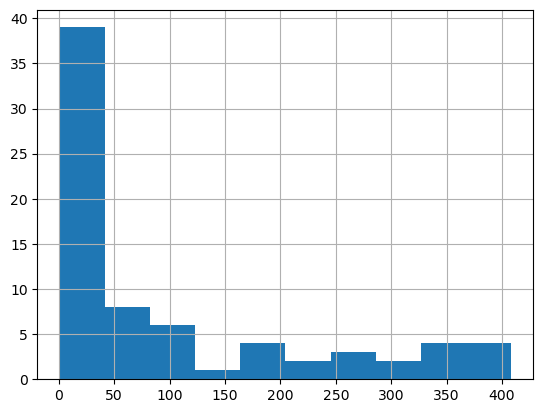

In [6]:
df['length'].value_counts().hist()

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2,random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df, eval_df = train_test_split(test_df, test_size=0.5,random_state=42)
test_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)
print(train_df.shape)
print(test_df.shape)
print(eval_df.shape)

(5966, 3)
(746, 3)
(746, 3)


In [8]:
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [10]:
train_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=train_df,
                           processor=image_processor,
                          tokenizer=tokenizer)
test_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=test_df,
                           processor=image_processor,
                          tokenizer=tokenizer)
eval_dataset = IAMDataset(root_dir=os.path.join(current_directory, 'IAM-data/img/'),
                           df=eval_df,
                           processor=image_processor,
                          tokenizer=tokenizer)

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 5966
Number of validation examples: 746
Number of test examples: 746


In [12]:
def check_tokenization():
    for i in range(len(train_dataset)):
        encoding = train_dataset[i]
        for k,v in encoding.items():
            if(k == 'labels' and v.shape[0] != 128):
                print(i)
# check_tokenization()

In [13]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "bert-base-uncased"
)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.11.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.self.key.weight', 'bert.encoder.layer.2.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.3.crossattention.output.LayerNorm.weight', 

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [14]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [15]:
cer_metric = evaluate.load("cer")

In [16]:
def compute_cer(pred_ids, label_ids):
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)


C:\Users\jl\Miniconda3\envs\torch\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# losses = []
# evals = []
for epoch in range(10):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    losses.append(train_loss/len(train_dataloader))
    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer 

    print("Validation CER:", valid_cer / len(eval_dataloader))
    evals.append(valid_cer / len(eval_dataloader))


  0%|          | 0/1492 [00:00<?, ?it/s]

Loss after epoch 0: 0.3915535121427065


  0%|          | 0/187 [00:00<?, ?it/s]

Validation CER: 1.0034582158872947


  0%|          | 0/1492 [00:00<?, ?it/s]

Loss after epoch 1: 0.28819029858640466


  0%|          | 0/187 [00:00<?, ?it/s]

Validation CER: 0.9402618691353016


  0%|          | 0/1492 [00:00<?, ?it/s]

Loss after epoch 2: 0.20788363096786128


  0%|          | 0/187 [00:00<?, ?it/s]

Validation CER: 0.9446838764521116


  0%|          | 0/1492 [00:00<?, ?it/s]

Loss after epoch 3: 0.16386817809975837


  0%|          | 0/187 [00:00<?, ?it/s]

Validation CER: 0.9575012431468755


  0%|          | 0/1492 [00:00<?, ?it/s]

Loss after epoch 4: 0.14457982560824453


  0%|          | 0/187 [00:00<?, ?it/s]

Validation CER: 1.0145365234277253


  0%|          | 0/1492 [00:00<?, ?it/s]

In [20]:
losses

[5.519170750242136,
 4.1938950311562335,
 3.4657131006826343,
 2.858018475707031,
 2.2489084583824503,
 1.6892989927018935,
 1.2312535580457376,
 0.91416958282045,
 0.6860485258175125,
 0.5230541787941718]

In [21]:
evals

[0.9603628095475437,
 0.9339282737936496,
 0.8844899749900363,
 0.9066451910948902,
 0.9133240189571943,
 1.0010268804708247,
 1.0104488860970504,
 0.9390999881273239,
 1.0093938761055394,
 1.002825845247308]

In [60]:
model.encoder.save_pretrained("./encoder")
model.decoder.save_pretrained("./decoder")

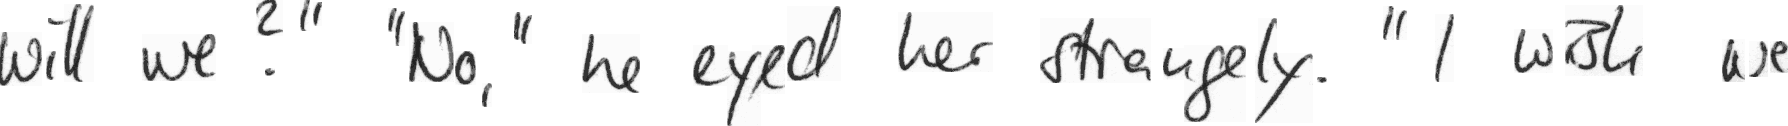

In [85]:
# for i in range(10):
sample = 700
encoding = test_dataset[sample]
image = Image.open(test_dataset.root_dir + test_df['file_name'][sample]).convert("RGB")
image

In [86]:
pred_labels = encoding['labels']
pred_labels[pred_labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(pred_labels, skip_special_tokens=True)
print(label_str)

will we? " " no, " he eyed her strangely. " i wish we


In [87]:
pred_labels

tensor([  101,  2097,  2057,  1029,  1000,  1000,  2053,  1010,  1000,  2002,
         7168,  2014, 13939,  1012,  1000,  1045,  4299,  2057,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [88]:
pred_labels = model.generate(torch.unsqueeze(encoding['pixel_values'], 0).to(device)).to('cpu')
print(pred_labels)
label_str = tokenizer.batch_decode(pred_labels, skip_special_tokens=True)
print(label_str)

tensor([[  101,   101,  2057,  1005,  2310,  2288,  2566, 20921,  1012,  1000,
          2339,  2123,  1005,  1056,  2017,  2191, 10340,  2000,   102,  1005]])
['we\'ve got pericles. " why don\'t you make proposals to \'']


In [65]:
model2 = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "./encoder", "./decoder"
)
# This is only for copying some specific attributes of this particular model.
# model.config = _model.config